In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import scipy.fftpack as sci
from astropy.time import Time
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.ndimage import shift
from scipy.optimize import curve_fit
from scipy.spatial.distance import cdist
from skimage.feature import peak_local_max
from scipy.ndimage import maximum_filter, label, find_objects

In [2]:
def master_dark(dark):
    hdul_dark = fits.open(dark)
    header_dark = hdul_dark[0].header
    image_dark = hdul_dark[0].data

#----------------------------------------------------------------------
# Cria uma "imagem" zerada, para que os darks sejam somados após o loop
#----------------------------------------------------------------------
    num_frames, width, height = image_dark.shape
    master_dark = np.zeros((width, height))
    space_dark = np.zeros((width, height))

#-------------------------------------------------------------------------------------------------
# Looping para carregar cada imagem do fits, aplicar a transformada e calcular o PS do master dark
#-------------------------------------------------------------------------------------------------
    for i in range(num_frames):
        image = image_dark[i]
        image_space = image_dark[i]

        fft_dark = sci.fft2(image)
        fft_normalized_dark = np.abs(fft_dark)
        fft_normalized_dark /= fft_normalized_dark.max()
        fft_shifted_dark = sci.fftshift(fft_normalized_dark)

        master_dark += fft_shifted_dark ** 2
        space_dark += image_space

#-----------------------------------------------------------------
# Tira a média do master dark para o mesmo ficar na escala correta
#-----------------------------------------------------------------
    master_dark /= num_frames
    space_dark /= num_frames

    return master_dark, space_dark

def pws(image_01, image_02, dark):
    #--------------------------------
    # Carrega e abre os dados do fits
    #--------------------------------
    hdul = fits.open(image_01)
    header_data = hdul[0].header
    image_data = hdul[0].data

    hdul_01 = fits.open(image_02)
    header_data_01 = hdul_01[0].header
    image_data_01 = hdul_01[0].data

    hdul_master_dark = fits.open(dark)
    header_master_dark = hdul_master_dark[0].header
    image_master_dark = hdul_master_dark[0].data

    #-------------------------------------------------------------------------------
    # Função que calcula a PWS, as imagens de longa exposição e extrai o master dark
    #-------------------------------------------------------------------------------
    def process_fit_cub(data, dark):
        num_frames, width, height = data.shape
        PWS = np.zeros((width, height))

        for i in range(num_frames):
            image = data[i] 
     
            fft = sci.fft2(image)
            fft_normalized = np.abs(fft)
            fft_normalized /= fft_normalized.max()
            fft_shifted = sci.fftshift(fft_normalized)
        
            power_spectrum = fft_shifted ** 2 - dark
        
            PWS += power_spectrum

        return PWS

    #---------------------------------------------
    # Calculo das PWS e imagens de longa exposição
    #---------------------------------------------
    PWS_01 = process_fit_cub(image_data, image_master_dark)
    PWS_02 = process_fit_cub(image_data_01, image_master_dark)

    PWS_mean = (PWS_01 + PWS_02) / 2

    return PWS_mean, PWS_01, PWS_02

def le_image(image_01, image_02, dark):
    hdul = fits.open(image_01)
    header_data = hdul[0].header
    image_data = hdul[0].data

    hdul_01 = fits.open(image_02)
    header_data_01 = hdul_01[0].header
    image_data_01 = hdul_01[0].data

    hdul_master_dark_spc = fits.open(dark)
    header_master_dark_spc = hdul_master_dark_spc[0].header
    master_dark_spc = hdul_master_dark_spc[0].data

    #-------------------------------------------------------------------------------
    # Função que calcula a PWS, as imagens de longa exposição e extrai o master dark
    #-------------------------------------------------------------------------------
    def process_fit_cub(data, dark_space):
        num_frames, width, height = data.shape
        LE_image = np.zeros((width, height))

        for i in range(num_frames):
            image = data[i] - dark_space
            LE_image += image

        return LE_image

    #---------------------------------------------
    # Calculo das PWS e imagens de longa exposição
    #---------------------------------------------
    LE_01 = process_fit_cub(image_data, master_dark_spc)
    LE_02 = process_fit_cub(image_data_01, master_dark_spc)


    LE_image_mean = (LE_01 + LE_02) / 2

    return LE_image_mean

def acf(pws_01, pws_02, psf):
    #--------------------------------
    # Carrega e abre os dados do fits
    #--------------------------------
    hdul_pws_I = fits.open(pws_01)  # Mostra informações sobre as extensões do FITS
    header_pws_I = hdul_pws_I[0].header
    pws_I = hdul_pws_I[0].data  # Normalmente a imagem está na primeira extensão

    hdul_pws_I_01 = fits.open(pws_02)  # Mostra informações sobre as extensões do FITS
    header_pws_I_01 = hdul_pws_I_01[0].header
    pws_I_01 = hdul_pws_I_01[0].data  # Normalmente a imagem está na primeira extensão

    hdul_psf_I = fits.open(psf)  # Mostra informações sobre as extensões do FITS
    header_psf_I = hdul_psf_I[0].header
    psf_I = hdul_psf_I[0].data  # Normalmente a imagem está na primeira extensão

    #---------------------------
    # Função que calcula as ACFs
    #---------------------------
    def ACF_calculation(PWS , PSF):
        with np.errstate(divide='ignore', invalid='ignore'):
            sci_I = np.divide(PWS, PSF, out=np.zeros_like(PWS), where=PSF != 0)
        fft_I = sci.fft2(sci_I) #Fazendo a transformada bidimensional
        normalized_fft_I = np.abs(fft_I) #Pegando os valores absolutos da FFT2
        normalized_fft_I /= normalized_fft_I.max() #Normalizando a FFT2 dividindo a FFT2 pelo seu valor máximo
        ACF = sci.fftshift(normalized_fft_I)

        return ACF

    ACF_01 = ACF_calculation(pws_I, psf_I)
    ACF_02 = ACF_calculation(pws_I_01, psf_I)

    ACF_mean = (ACF_01 + ACF_02) / 2

    return ACF_mean

def HR_image(image_01, image_02, dark):

#--------------------------------
# Carrega e abre os dados do fits
#--------------------------------
    HR_hdul = fits.open(image_01)
    HR_header = HR_hdul[0].header
    HR_data = HR_hdul[0].data

    HR_hdul_01 = fits.open(image_02)
    HR_header_01 = HR_hdul_01[0].header
    HR_data_01 = HR_hdul_01[0].data

    HR_hdul_master_dark = fits.open(dark)
    HR_header_master_dark = HR_hdul_master_dark[0].header
    HR_master_dark = HR_hdul_master_dark[0].data

#------------------------------------------------
# Função que calcula as imagens de alta resolução
#------------------------------------------------
    def hight_resolution_image(data, dark):
        num_frames, width, height = data.shape
        centro_y, centro_x = height//2, width//2
    
        AR_image = np.zeros((width, height))
    
        for i in range(num_frames):
            image = data[i] - dark # Pega a i-ésima imagem
            y_max, x_max = np.unravel_index(np.argmax(image), image.shape)

            dx = centro_x - x_max
            dy = centro_y - y_max
    
            imagem_alinhada = shift(image, shift=(dy, dx), order=1, mode='constant', cval=0.0) # Linha que alinha o centro das imagens do fits com o da imagem gerada (AR_image)

            AR_image +=imagem_alinhada

        return AR_image

    HR_01 = hight_resolution_image(HR_data, HR_master_dark)
    HR_02 = hight_resolution_image(HR_data_01, HR_master_dark)

    HR_mean = (HR_01 + HR_02) / 2

    return HR_mean

def dist_theta(image):

#--------------------------------
# Carrega e abre os dados do fits
#--------------------------------
    hdul_ar = fits.open(image)  # Mostra informações sobre as extensões do FITS
    header_ar = hdul_ar[0].header
    image_ar = hdul_ar[0].data  # Normalmente a imagem está na primeira extensão

    altura, largura = image_ar.shape

#---------------------------------------------------------------------------------
# Função que localiza e indica o valor do pico máximo (estrela primária) da imagem
#---------------------------------------------------------------------------------
    def fluxo_maximo(img):
        flux_max = np.amax(img) # Encontra o valor de máximo dentro da matriz (imagem)
        y_max, x_max = np.unravel_index(np.argmax(img), img.shape) # Encontra as coordenadas do máximo

        return (x_max, y_max)

#---------------------------------------------------------------------------------
# Função que localiza e indica os valores dos picos secundários (demais estrelas) da imagem
#---------------------------------------------------------------------------------
    def fluxo_secundário(img, num_picos, dist_minima=1, limiar_relativo=0.009):
        limiar = limiar_relativo * np.max(img)

        peaks = peak_local_max(img, min_distance=dist_minima, threshold_abs=limiar, num_peaks=num_picos + 1, exclude_border=False)

        # Extrai os fluxos dos picos encontrados, onde [:, 0] pega as linhas da coluna 0 (y) e [:, 1] pega as linhas da coluna 1(x)
        fluxos = img[peaks[:, 0], peaks[:, 1]]
    
        indices_ord = np.argsort(fluxos)[::-1] # Ordena os valores do fluxo em ordem crescente
        peaks_ord = peaks[indices_ord]
        fluxos_ord = fluxos[indices_ord]  
        

        real_peaks = [] # Essa looping está selecionando os "picos reais", desconsiderando aqueles pixels que estão ainda brilhantes devido ao mesmo pico
        for i, coord in enumerate(peaks_ord):
            if all(np.linalg.norm(coord - np.array(outro)) >= dist_minima for outro in real_peaks):
                real_peaks.append(coord)
            if len(real_peaks) >= num_picos:
                break
    
        real_peaks = np.array(real_peaks)
        selected_flux = img[real_peaks[:, 0], real_peaks[:, 1]]

        # Converte para (x, y) para manter o padrão do restante do código
        pos_xy = np.array([[x, y] for y, x in real_peaks])
    
        return pos_xy

    posicoes = fluxo_secundário(image_ar, 2, dist_minima=1, limiar_relativo=0.009)

    (x_max, y_max) = fluxo_maximo(image_ar)
    posicoes_sec = posicoes[1:]

    altura, largura = image_ar.shape[:2]

    centro_x = largura/2
    centro_y = altura//2

    def distancia(x_c, y_c, x, y):
        d_x = x - x_c
        d_y = y - y_c
        d = np.sqrt((d_x**2) + (d_y)**2)
        theta = np.degrees(np.arctan(np.abs(d_y)/d_x))

        return d, theta
    
    dist, angulo = distancia(centro_x, centro_y, posicoes_sec[0, 0], posicoes_sec[0, 1])

    return dist, angulo

def mag_diff(image):

#--------------------------------
# Carrega e abre os dados do fits
#--------------------------------
    hdul_ar = fits.open(image)  # Mostra informações sobre as extensões do FITS
    header_ar = hdul_ar[0].header
    image_ar = hdul_ar[0].data  # Normalmente a imagem está na primeira extensão

    altura, largura = image_ar.shape

#---------------------------------------------------------------------------------
# Função que localiza e indica o valor do pico máximo (estrela primária) da imagem
#---------------------------------------------------------------------------------
    def fluxo_maximo(img):
        flux_max = np.amax(img) # Encontra o valor de máximo dentro da matriz (imagem)
        y_max, x_max = np.unravel_index(np.argmax(img), img.shape) # Encontra as coordenadas do máximo

        return flux_max

#---------------------------------------------------------------------------------
# Função que localiza e indica os valores dos picos secundários (demais estrelas) da imagem
#---------------------------------------------------------------------------------
    def fluxo_secundário(img, num_picos, dist_minima=1, limiar_relativo=0.009):
        limiar = limiar_relativo * np.max(img)

        # Retorna coordenadas dos picos: array (N, 2), com (linha=y, coluna=x)
        peaks = peak_local_max(img, min_distance=dist_minima, threshold_abs=limiar, num_peaks=num_picos + 1, exclude_border=False)

    # Extrai os fluxos dos picos encontrados, onde [:, 0] pega as linhas da coluna 0 (y) e [:, 1] pega as linhas da coluna 1(x)
        fluxo = img[peaks[:, 0], peaks[:, 1]]
    
        indices_ord = np.argsort(fluxo)[::-1] # Ordena os valores do fluxo em ordem crescente
        peaks_ord = peaks[indices_ord]
        fluxos_ord = fluxo[indices_ord]  
        

        real_peaks = [] # Essa looping está selecionando os "picos reais", desconsiderando aqueles pixels que estão ainda brilhantes devido ao mesmo pico
        for i, coord in enumerate(peaks_ord):
            if all(np.linalg.norm(coord - np.array(outro)) >= dist_minima for outro in real_peaks):
                real_peaks.append(coord)
            if len(real_peaks) >= num_picos:
                break
    
        real_peaks = np.array(real_peaks)
        selected_flux = img[real_peaks[:, 0], real_peaks[:, 1]]

        # Converte para (x, y) para manter o padrão do restante do código
        pos_xy = np.array([[x, y] for y, x in real_peaks])
    
        return selected_flux

    flux_sec = fluxo_secundário(image_ar, 2, dist_minima=1, limiar_relativo=0.009)

    flux_max = fluxo_maximo(image_ar)
    flux_sec = flux_sec[1:]

    def dif_mag(f_1, f_2):
        diferenca_de_magnitude = -2.5*np.log10((f_2/f_1))
        return diferenca_de_magnitude
    
    mag_dif = dif_mag(flux_max, flux_sec[0])
    
    return mag_dif

def seeing(image):
    LE_hdul = fits.open(image)
    LE_header_data = LE_hdul[0].header
    LE_data = LE_hdul[0].data

    def gaussian_2d(xy, amp, x0, y0, sigma_x, sigma_y, offset):
        x, y = xy
        g = offset + amp * np.exp(-(((x-x0)**2)/(2*sigma_x**2) + ((y-y0)**2)/(2*sigma_y**2)))
        return g.ravel()

#------------------------------------------------------
# Determina a posição do pixel mais brilhante da imagem
#------------------------------------------------------
    def pos_max(img):
        y_max, x_max = np.unravel_index(np.argmax(img), img.shape)
        return x_max, y_max

#-------------------------------------------------------------------
# Faz o recorte da região ao redor do ponto mais brilhante da imagem
#-------------------------------------------------------------------
    x_center, y_center = pos_max(LE_data) # Centraliza o corte no pixel mais brilhante
    width, height = LE_data.shape

#--------------------------------
# Coordenadas do ajuste Gaussiano
#-------------------------------- 
    yy, xx = np.indices(LE_data.shape)
    initial_guess = (LE_data.max(), x_center, y_center, width / 4, height / 4, np.median(LE_data))

#-------------------
# Ajusta a Gaussiana
#-------------------
    lower_bounds = [   0,       0,      0,      0.1,     0.1,     -np.inf ] # Linhas escrita para que sigma x e y sejam positivos
    upper_bounds = [ np.inf,  width, height,   np.inf,  np.inf,  np.inf ]

    popt, pcov = curve_fit(gaussian_2d, (xx, yy), LE_data.ravel(), p0=initial_guess, bounds=(lower_bounds, upper_bounds), maxfev=10000)

#---------------------------
# Extrai os valores de sigma
#---------------------------
    sigma_x, sigma_y = popt[3], popt[4]

#---------------
# Calcula a FWHM
#---------------
    fwhm_x = 2.355 * sigma_x
    fwhm_y = 2.355 * sigma_y
    fwhm_mean = (fwhm_x + fwhm_y) / 2

    escala = 0.06  # exemplo em arcsec/pixel
    seeing_arcsec = ((fwhm_x + fwhm_y)/2) * escala

    return seeing_arcsec

def position(image):
    hdul_ar = fits.open(image)  # Mostra informações sobre as extensões do FITS
    header_ar = hdul_ar[0].header
    image_ar = hdul_ar[0].data  # Normalmente a imagem está na primeira extensão

    altura, largura = image_ar.shape

#---------------------------------------------------------------------------------
# Função que localiza e indica o valor do pico máximo (estrela primária) da imagem
#---------------------------------------------------------------------------------
    def fluxo_maximo(img):
        flux_max = np.amax(img) # Encontra o valor de máximo dentro da matriz (imagem)
        y_max, x_max = np.unravel_index(np.argmax(img), img.shape) # Encontra as coordenadas do máximo

        return (x_max, y_max)

#---------------------------------------------------------------------------------
# Função que localiza e indica os valores dos picos secundários (demais estrelas) da imagem
#---------------------------------------------------------------------------------
    def fluxo_secundário(img, num_picos, dist_minima=1, limiar_relativo=0.009):
        limiar = limiar_relativo * np.max(img) # "filtra" os valores de fluxo que se quer ou não ler.

        peaks = peak_local_max(img, min_distance=dist_minima, threshold_abs=limiar, num_peaks=num_picos + 1, exclude_border=False)

        # Extrai os fluxos dos picos encontrados, onde [:, 0] pega as linhas da coluna 0 (y) e [:, 1] pega as linhas da coluna 1(x)
        fluxos = img[peaks[:, 0], peaks[:, 1]]
    
        indices_ord = np.argsort(fluxos)[::-1] # Ordena os valores do fluxo em ordem crescente
        peaks_ord = peaks[indices_ord]
        fluxos_ord = fluxos[indices_ord]  
        

        real_peaks = [] # Essa looping está selecionando os "picos reais", desconsiderando aqueles pixels que estão ainda brilhantes devido ao mesmo pico
        for i, coord in enumerate(peaks_ord):
            if all(np.linalg.norm(coord - np.array(outro)) >= dist_minima for outro in real_peaks):
                real_peaks.append(coord)
            if len(real_peaks) >= num_picos:
                break
    
        real_peaks = np.array(real_peaks)
        selected_flux = img[real_peaks[:, 0], real_peaks[:, 1]]

        # Converte para (x, y) para manter o padrão do restante do código
        pos_xy = np.array([[x, y] for y, x in real_peaks])

        return pos_xy

    posicoes = fluxo_secundário(image_ar, 2, dist_minima=1, limiar_relativo=0.009)

    (x_max, y_max) = fluxo_maximo(image_ar)
    posicoes_sec = posicoes[1:]

    return (x_max, y_max), posicoes_sec

def julian_epoch(time):
    dt = datetime.fromisoformat(time)
    date = Time(dt, scale='utc')
    epoch = date.jyear

    return epoch 

----

Master Dark.

----

In [ ]:
dark = 

freq_dark, space_dark = master_dark(dark)

hdu = fits.PrimaryHDU(freq_dark)
hdu.writeto(r"D:\22abr22\Master_dark\test00", overwrite=True)

hdu = fits.PrimaryHDU(space_dark)
hdu.writeto(r"D:\22abr22\Master_dark\test", overwrite=True)

----

Power Spectrum (PWS), long exposure (LE) and high exposure (HR) images calculation. 

-----------------------------------------------------------------------------------------------

In [16]:
image = r"D:\22abr22\22abr22\14040-4437-R-0049.fits"
image_01 = r"D:\22abr22\22abr22\14040-4437-R-0049.fits"
dark = r"D:\22abr22\Master_dark\master_dark300-0003.fits"
space_dark = r"D:\22abr22\Master_dark\space_master_dark300-0003.fits"

In [ ]:
pws_mean, pws_01, pws_02 = pws(image, image_01, dark)
LE_image = le_image(image, image_01, space_dark)
hr_image = HR_image(image, image_01, space_dark)

hdu = fits.PrimaryHDU(LE_image)
hdu.writeto('LE-14040-4437-R.fits', overwrite=True)

hdu = fits.PrimaryHDU(hr_image)
hdu.writeto('HR-14040-4437-R.fits', overwrite=True)

hdu = fits.PrimaryHDU(pws_mean)
hdu.writeto('PWS-14040-4437-R.fits', overwrite=True)

if image != image_01:
    hdu = fits.PrimaryHDU(pws_01)
    hdu.writeto('PWS_01-14040-4437-I.fits', overwrite=True)

    hdu = fits.PrimaryHDU(pws_02)
    hdu.writeto('PWS_02-14040-4437-I.fits', overwrite=True)



----

Autorcorrelation function (ACF) calculation.

----

In [15]:
pws_01 = r"D:\22abr22\PWS\PWS-14040-4437-I.fits"
pws_02 = r"D:\22abr22\PWS\PWS-14040-4437-I.fits"
psf_I = r"D:\22abr22\PWS\PWS-16020-1118-I.fits"
psf_R = r"D:\22abr22\PWS\PWS-16020-1118-R.fits"
psf_V = r"D:\22abr22\PWS\PWS-16020-1118-R.fits"

In [ ]:
ACF = acf(pws_01, pws_02, psf_I)

hdu = fits.PrimaryHDU(ACF)
hdu.writeto('ACF-14040-4437-I.fits', overwrite=True)

----

Differential aperture photometry calculation

----

In [76]:
autocorr = r"D:\22abr22\ACF_Ref_16020-1118\ACF-14145-2914-I.fits"
HR = r"D:\22abr22\Alta_resolucao\HR_image-14145-2914-I.fits"
time = '2022-04-23T05:26:08-03:00'

dist, theta = dist_theta(autocorr)
#diff_mag = mag_diff(HR)
epoch = julian_epoch(time)

print(f'Julian Epoch = {epoch:.5f}')
print(f'Angle = {theta:.1f}')
#print(f'Madnitude diffenrece = {diff_mag:.2f}')
print(f'Distace = {dist:.2f}')



Julian Epoch = 2022.30760
Angle = -11.3
Distace = 10.20


ACF = [[118 130]]
HR = [[119 129]]


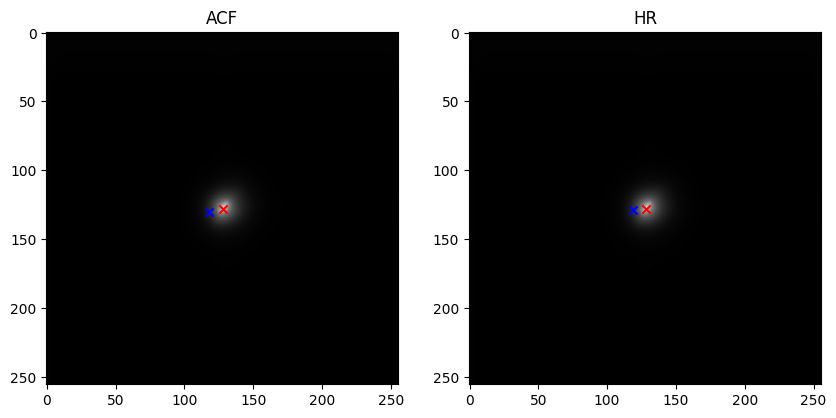

In [77]:
hdul = fits.open(r"D:\22abr22\ACF_Ref_16020-1118\ACF-15420+0027_O-R.fits")
header = hdul[0].header
data = hdul[0].data

hdul_01 = fits.open(r"D:\22abr22\Alta_resolucao\HR_image-15420+0027_O-R.fits")  # Mostra informações sobre as extensões do FITS
header_01 = hdul_01[0].header
data_01 = hdul_01[0].data 

(x_max, y_max), pos_acf = position(autocorr)
(x_max_01, y_max_01), pos_hr = position(HR)
print(f'ACF = {pos_acf}')
print(f'HR = {pos_hr}')


plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(data, cmap='gray', origin='upper')
plt.scatter(x_max, y_max, color='red', marker='x')
plt.imshow(data_01, cmap='gray', origin='upper')
for i in range(len(pos_acf)):
    plt.scatter(pos_acf[i, 0], pos_acf[i, 1], color='b', marker='x')
plt.title("ACF")

plt.subplot(1 , 2, 2)
plt.imshow(data_01, cmap='gray', origin='upper')
plt.scatter(x_max_01, y_max_01, color='red', marker='x')
plt.imshow(data_01, cmap='gray', origin='upper')
for i in range(len(pos_hr)):
    plt.scatter(pos_hr[i, 0], pos_hr[i, 1], color='b', marker='x')
plt.title("HR")
plt.show()